<a href="https://colab.research.google.com/github/Veldora00/Veldora00/blob/main/glodwithmacro10y2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
19/19 [==============================] - 1s 17ms/step - loss: 0.6954 - val_loss: 1.8572
Epoch 2/50
19/19 [==============================] - 0s 5ms/step - loss: 0.6456 - val_loss: 1.8559
Epoch 3/50
19/19 [==============================] - 0s 5ms/step - loss: 0.6029 - val_loss: 1.8548
Epoch 4/50
19/19 [==============================] - 0s 6ms/step - loss: 0.5661 - val_loss: 1.8539
Epoch 5/50
19/19 [==============================] - 0s 6ms/step - loss: 0.5351 - val_loss: 1.8521
Epoch 6/50
19/19 [==============================] - 0s 5ms/step - loss: 0.5090 - val_loss: 1.8488
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 0.4868 - val_loss: 1.8441
Epoch 8/50
19/19 [==============================] - 0s 6ms/step - loss: 0.4684 - val_loss: 1.8382
Epoch 9/50
19/19 [==============================] - 0s 6ms/step - loss: 0.4529 - val_loss: 1.8304
Epoch 10/50
19/19 [==============================] - 0s 5ms/step - loss: 0.4400 - val_loss: 1.8213
Epoch 11/50
19/19 

Training Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

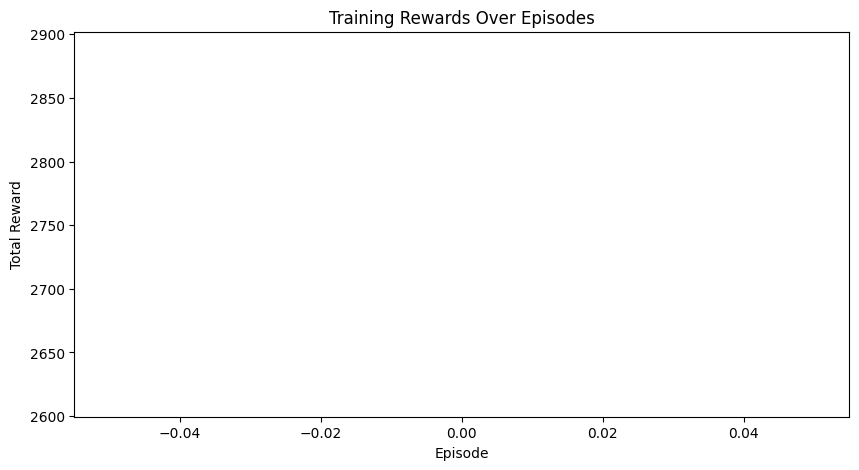

Training Episodes:  10%|█         | 100/1000 [02:31<22:43,  1.52s/it]

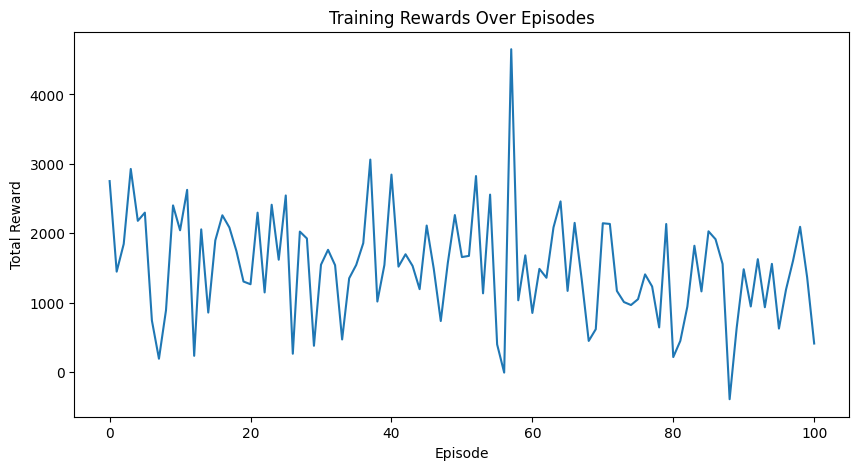

Training Episodes:  20%|██        | 200/1000 [04:58<19:13,  1.44s/it]

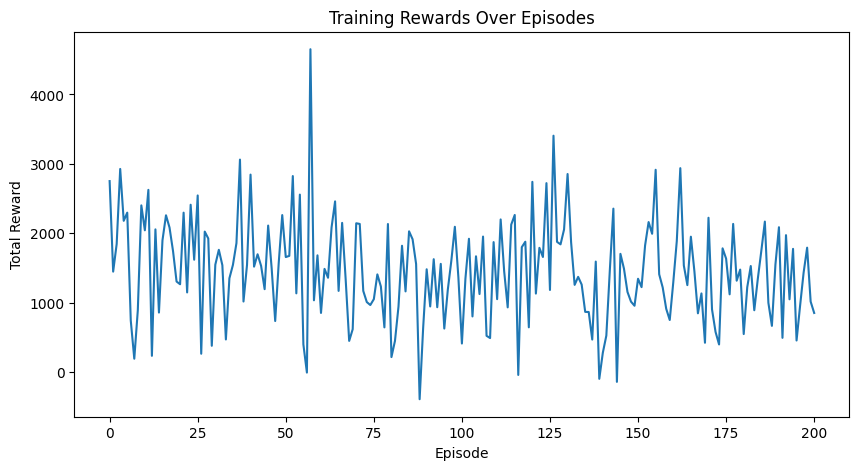

Training Episodes:  30%|███       | 300/1000 [07:17<15:56,  1.37s/it]

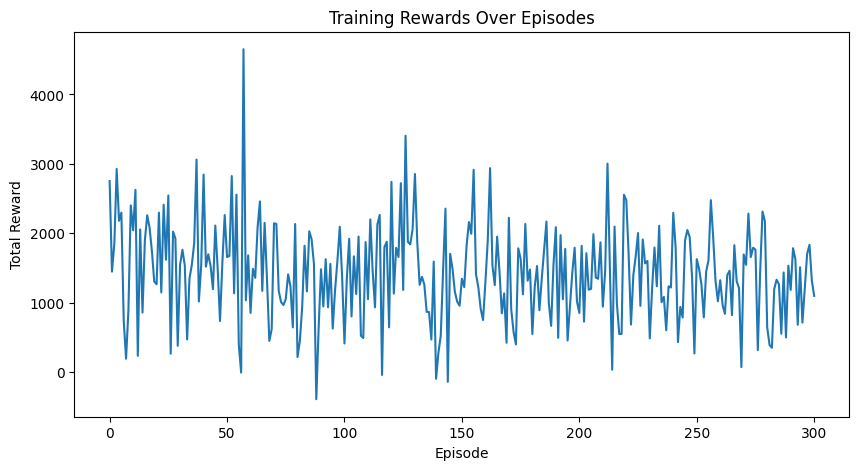

Training Episodes:  40%|████      | 400/1000 [09:36<12:18,  1.23s/it]

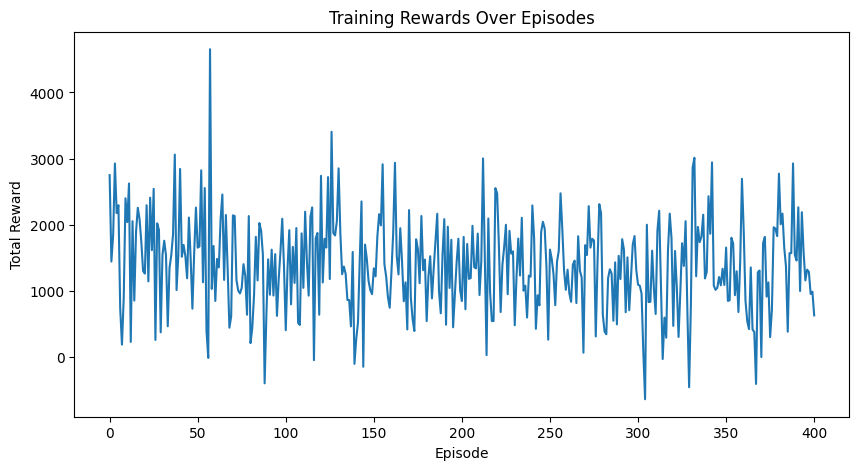

Training Episodes:  50%|█████     | 500/1000 [11:59<11:43,  1.41s/it]

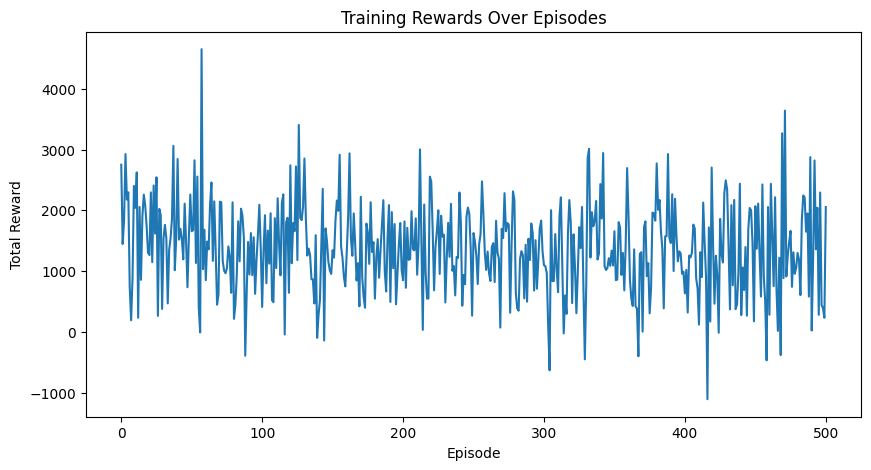

Training Episodes:  60%|██████    | 600/1000 [14:22<09:03,  1.36s/it]

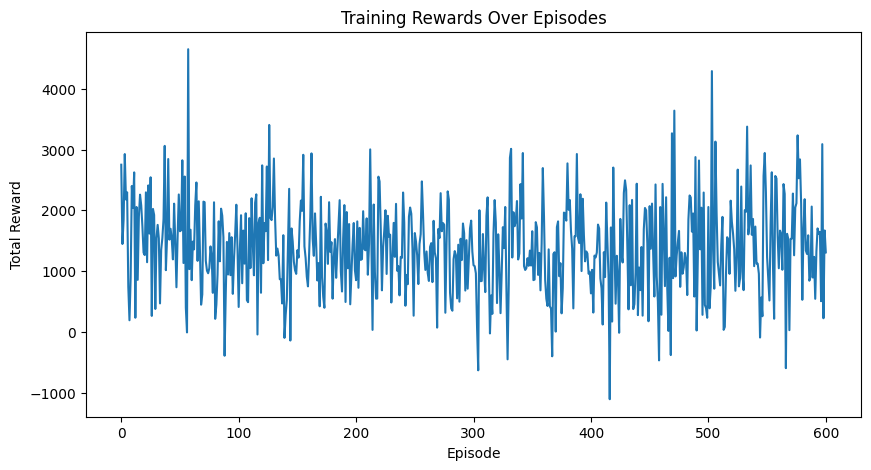

Training Episodes:  70%|███████   | 700/1000 [16:43<08:10,  1.63s/it]

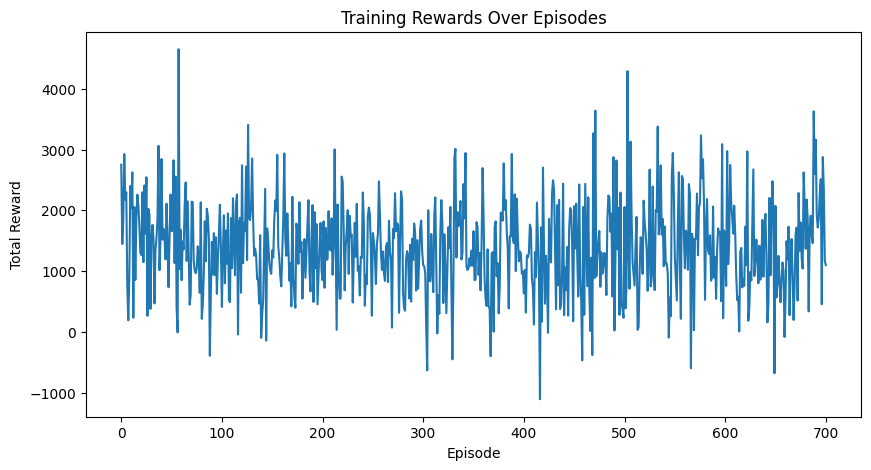

Training Episodes:  80%|████████  | 800/1000 [19:09<05:10,  1.55s/it]

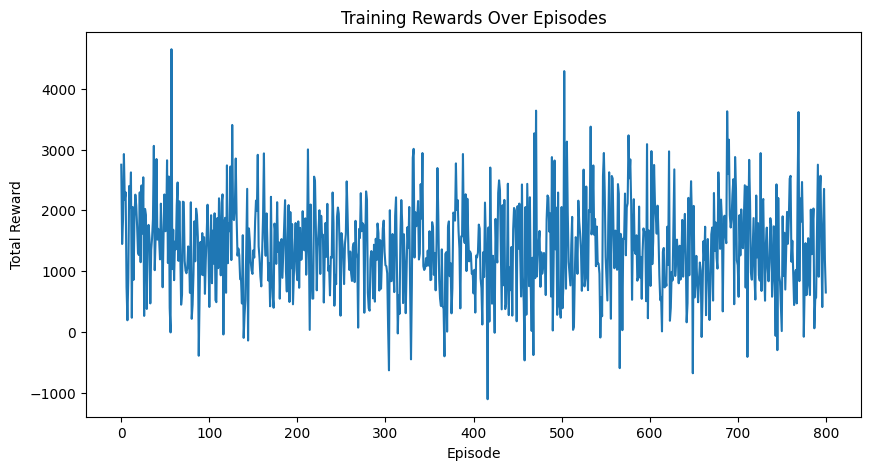

Training Episodes:  90%|█████████ | 900/1000 [21:48<02:38,  1.58s/it]

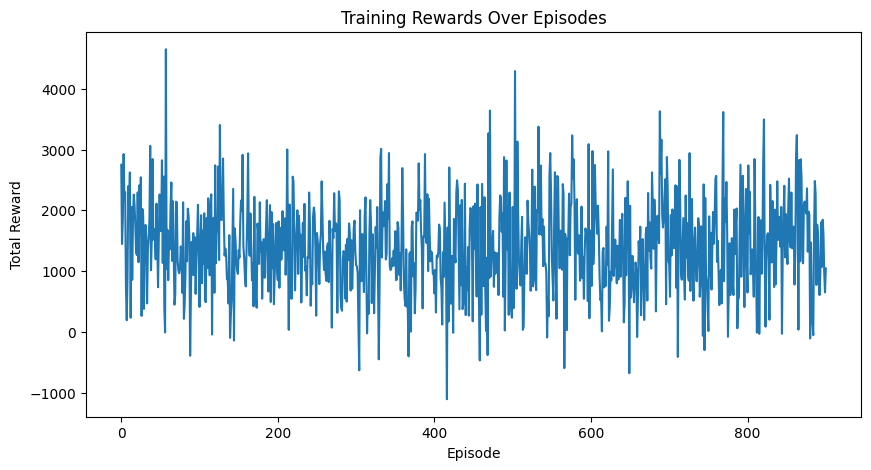

Training Episodes: 100%|██████████| 1000/1000 [24:08<00:00,  1.45s/it]


Training finished and Q-table saved.



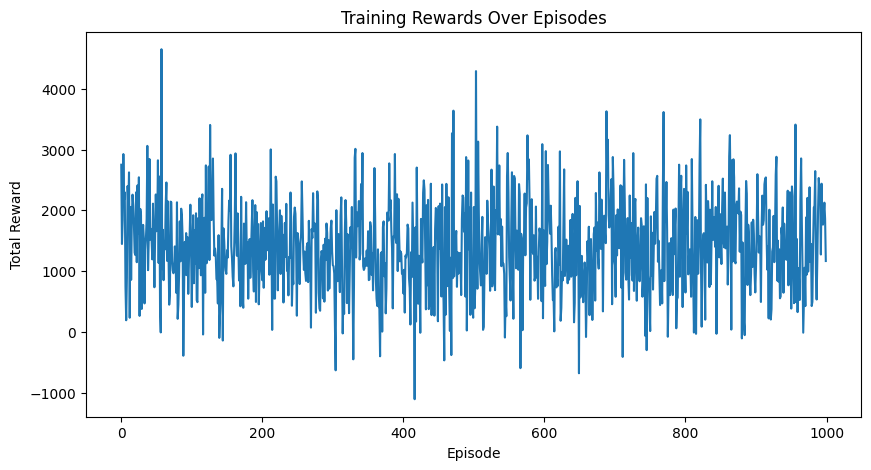

Total reward: 2138.4988403320312


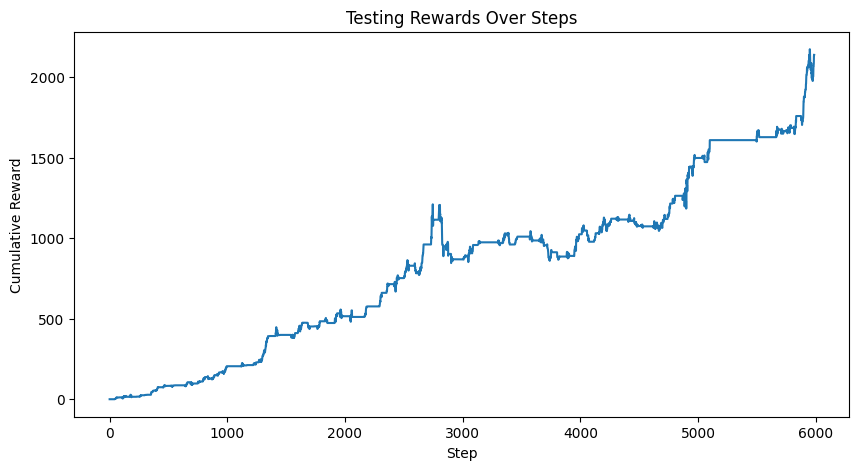

In [ ]:
import os
import pickle
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from gym import spaces
import random
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Function to download daily data for Gold from Yahoo Finance
def download_daily_data(symbol, period='max'):
    data = yf.download(tickers=symbol, interval='1d', period=period)
    data.reset_index(inplace=True)
    if 'Date' in data.columns:
        data.rename(columns={'Date': 'timestamp'}, inplace=True)
    else:
        print("Error: Could not find Date column in downloaded data.")
        return None

    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
    return data

# Function to download macroeconomic data from FRED
def download_fred_data(series_id, api_key):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json'
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if 'observations' in data:
            observations = data['observations']
            df = pd.DataFrame(observations)
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            df[series_id] = pd.to_numeric(df['value'], errors='coerce')
            df.drop(columns=['value', 'realtime_start', 'realtime_end'], inplace=True)
            return df
        else:
            print(f"Error: 'observations' key not found in response for {series_id}. Check API response.")
            return None
    else:
        print(f"Error: Failed to fetch data for {series_id}. Status code: {response.status_code}")
        return None

# Function to calculate support and resistance levels
def calculate_support_resistance(data, window=60):
    data['support'] = data['Low'].rolling(window, min_periods=1).min()
    data['resistance'] = data['High'].rolling(window, min_periods=1).max()
    return data

# Replace with your FRED API key
fred_api_key = 'a'

# Step 1: Download daily data for Gold
symbol = 'GC=F'  # Gold futures symbol
daily_data = download_daily_data(symbol)

# Step 2: Download macroeconomic data from FRED
series_ids = ['CPIAUCSL', ]
fred_data = [download_fred_data(series_id, fred_api_key) for series_id in series_ids]
macro_data = pd.concat(fred_data, axis=1)

# Step 3: Calculate support and resistance levels
daily_data = calculate_support_resistance(daily_data)

# Merge macroeconomic data with daily Gold data
# We need to forward fill macroeconomic data to align it with daily data timestamps
macro_data_ffill = macro_data.resample('D').ffill().reindex(daily_data.index, method='ffill')
data = daily_data.join(macro_data_ffill)

# Handle missing values before normalization
data.fillna(method='ffill', inplace=True)  # Forward fill missing values
data.fillna(method='bfill', inplace=True)  # Backfill any remaining missing values

# Select relevant features to reduce state space size
selected_features = ['Close', 'Volume', 'CPIAUCSL']
data = data[selected_features]

# Normalize the data
scaler = StandardScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

# Train an Autoencoder
input_dim = data_normalized.shape[1]
encoding_dim = 3

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation='linear')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(data_normalized, data_normalized, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

# Extract encoded features
encoder_model = Model(inputs=input_layer, outputs=encoder)
encoded_features = pd.DataFrame(encoder_model.predict(data_normalized), index=data_normalized.index)

# Train a Random Forest classifier
# Creating a target variable for price direction
data['target'] = np.sign(data['Close'].diff().shift(-1))
data['target'].fillna(0, inplace=True)

# Split the data into training and test sets
split_date = '2023-01-01'
train_features = encoded_features[data.index < split_date]
test_features = encoded_features[data.index >= split_date]
train_target = data['target'][data.index < split_date]
test_target = data['target'][data.index >= split_date]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_features, train_target)
predictions = rf.predict(test_features)
accuracy = accuracy_score(test_target, predictions)

print(f"Random Forest accuracy: {accuracy}")

# Generate signals using the trained Random Forest
data['signal'] = rf.predict(encoded_features)

# Integrate signals into the RL environment
class TradingEnvWithSignals(gym.Env):
    def __init__(self, data):
        super(TradingEnvWithSignals, self).__init__()
        self.data = data
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(data.shape[1],))
        self.action_space = spaces.Discrete(3)
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.current_step = 0  # Reset to the start if we reach the end

        reward = 0
        done = self.current_step >= len(self.data) - 1
        obs = self.data.iloc[self.current_step].values

        if action == 1:  # Buy
            reward = self.data['Close'].iloc[self.current_step] - self.data['Close'].iloc[self.current_step - 1]
        elif action == 2:  # Sell
            reward = self.data['Close'].iloc[self.current_step - 1] - self.data['Close'].iloc[self.current_step]

        if self.data['signal'].iloc[self.current_step] == action:
            reward += 1  # Reward for following the signal

        return obs, reward, done, {}

    def render(self, mode='human', close=False):
        pass

env = TradingEnvWithSignals(data)

# Step 6: Train and Evaluate the Q-learning Model
# Initialize Q-table
num_states = 3  # Reduced number of discrete states for each feature
num_state_combinations = num_states ** env.observation_space.shape[0]

# Check if the number of states is too large
if num_state_combinations > 1e6:
    raise MemoryError(f"Number of state combinations ({num_state_combinations}) is too large for Q-learning. Consider reducing num_states or the number of features.")

# Function to save Q-table
def save_q_table(q_table, filename='q_table.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(q_table, f)

# Function to load Q-table
def load_q_table(filename='q_table.pkl'):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    else:
        return np.zeros([num_state_combinations, env.action_space.n])

q_table = load_q_table()

# Hyperparameters
alpha = 0.1
gamma = 0.8
epsilon = 0.3

rewards = []

# Training the Q-learning model with progress bar
for episode in tqdm(range(1000), desc="Training Episodes"):
    state = env.reset()
    discrete_state = (state * num_states).astype(int) % num_states
    state_index = np.ravel_multi_index(discrete_state, [num_states] * env.observation_space.shape[0])
    done = False
    total_reward = 0

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state_index])  # Exploit learned values

        next_state, reward, done, _ = env.step(action)
        next_discrete_state = (next_state * num_states).astype(int) % num_states
        next_state_index = np.ravel_multi_index(next_discrete_state, [num_states] * env.observation_space.shape[0])

        old_value = q_table[state_index, action]
        next_max = np.max(q_table[next_state_index])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state_index, action] = new_value

        state = next_state
        state_index = next_state_index
        total_reward += reward

    rewards.append(total_reward)

    # Save progress every 100 episodes
    if episode % 100 == 0:
        save_q_table(q_table)
        # Visualize partial results
        plt.figure(figsize=(10, 5))
        plt.plot(rewards)
        plt.title('Training Rewards Over Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

save_q_table(q_table)
print("Training finished and Q-table saved.\n")

# Plot training rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title('Training Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Testing the trained model
state = env.reset()
discrete_state = (state * num_states).astype(int) % num_states
state_index = np.ravel_multi_index(discrete_state, [num_states] * env.observation_space.shape[0])
done = False
total_reward = 0

test_rewards = []

while not done:
    action = np.argmax(q_table[state_index])
    next_state, reward, done, _ = env.step(action)
    total_reward += reward

    state = next_state
    discrete_state = (state * num_states).astype(int) % num_states
    state_index = np.ravel_multi_index(discrete_state, [num_states] * env.observation_space.shape[0])

    test_rewards.append(total_reward)

print(f"Total reward: {total_reward}")

# Plot testing rewards
plt.figure(figsize=(10, 5))
plt.plot(test_rewards)
plt.title('Testing Rewards Over Steps')
plt.xlabel('Step')
plt.ylabel('Cumulative Reward')
plt.show()
